# Проект №4. Кредитный скоринг 

In [14]:
from pandas import Series
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn import metrics # инструменты для оценки точности модели

import os

# check version number
#import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

from imblearn.under_sampling import RandomUnderSampler
from pandas_profiling import ProfileReport

from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from itertools import combinations

from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


In [15]:
# Для воспроизводимости результатов зададим:
# - общий параметр для генерации случайных чисел
RANDOM_SEED = 42
CURRENT_DATE = pd.to_datetime('01/01/2020')
#Путь к 'submission.csv'
base_path = './data/kaggle/sf-dst-scoring/'
submission_path = os.path.join(base_path, 'submission.csv')
train_path = os.path.join(base_path, 'train.csv')
test_path = os.path.join(base_path, 'test.csv')

In [16]:
# Для переносимости кода, создаем requirements.txt
!pip freeze > ./data/kagle/sf-dst-scoring/requirements.txt

The system cannot find the path specified.


In [17]:
def load_data():

    # Загружаем тренеровочный (train/test) и тестовый(для submission)
    df_train = pd.read_csv(train_path)
    df_kaggle= pd.read_csv(test_path)
    # Помечаем датасеты как тренировочный True vs False - только для Submission
    df_train['train'] = 1
    df_kaggle['train'] = 0
    # Для тестового (для submission) датасета добавляем столбец default == -1, чтоб при объединении не было NaN 
    df_kaggle['default'] = -1
    df = pd.concat([df_train, df_kaggle])
    df = df.reset_index()
    #print(df.columns)
    df.drop('index', axis=1, inplace = True)
    return df

In [18]:
def identify_outliers():
    '''
    identify outliers in the training dataset
    return mask; mask - rows without outliers
    '''
    lof = LocalOutlierFactor() #A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space
    df_outliers = train.loc[train.train==True,['income', 'decline_app_cnt', 'bki_request_cnt']]
    yhat = lof.fit_predict(df_outliers.values)
    # select all rows that are not outliers
    mask = yhat != -1 # lines without outliers
    outliers_freq = (train[train.train==True].shape[0] - mask.sum()) / train[train.train==True].shape[0]
    
    return mask, outliers_freq

In [19]:
def transform_data(showgraphs=False):
    '''
    Импутация train['education'] через SimpleImputer
    Прологарифмируем и посмотрим новое распределение age, decline_app_cnt, score_bki (?), bki_request_cnt, income
    Для бинарных признаков мы будем использовать LabelEncode
    '''
    # Импутация train['education'] через SimpleImputer
    imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose = 1, add_indicator=False, copy=False)
    train.education = imr.fit_transform(train.education.values.reshape(-1, 1))

    # прологарифмируем и посмотрим новое распределение age, decline_app_cnt, score_bki (?), bki_request_cnt, income
    log_cols = ['age',  'income', 'score_bki_income', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'score_bki_income',  'days_from_CD', 'delta_app']
    for i in log_cols:       
        #train[i][train[i] > 0] = np.log(train[i][train[i] > 0])
        train[i] = np.log(train[i]+1)
        if showgraphs:
            plt.figure()
            sns.distplot(train[i], kde = False, rug=False)
            plt.title(i)
    # if showgraphs:    
    #     sns.boxplot(x='default', y='age', data=train);
    #     sns.boxplot(x='default', y='decline_app_cnt', data=train);
    #     sns.boxplot(x='default', y='bki_request_cnt', data=train);
    #     sns.boxplot(x='default', y='income', data=train, );
    # Для бинарных признаков мы будем использовать LabelEncoder
    label_encoder = LabelEncoder()
    for column in bin_cols + cat_cols:
        train[column] = label_encoder.fit_transform(train[column])

In [20]:
def get_test_kaggle_datasets(filter=False):
    '''
    получаем датасеты X_для_train, Y_для_train, X_для_kaggle
    '''
    # кодируем признаки    
    X_cat = OneHotEncoder(sparse = False, drop = 'first').fit_transform(train[cat_cols].values)

    poly = PolynomialFeatures(2)
    X_PF = poly.fit_transform(train[num_cols].values)
    X_num = RobustScaler().fit_transform(X_PF) # не чувствителен к выбросам

    # Объединяем
    X = np.hstack([X_num, X_cat, train[bin_cols].values])
    train_or_kaggle_filter = X[:,-1].astype('bool')
    #train
    

    Y_t = train[train_or_kaggle_filter]['default'].values
    X_t = X[train_or_kaggle_filter][:,:-1] #отрезаем train

    # filter!
    if not isinstance(filter, bool):
        Y_t = Y_t[filter]
        X_t = X_t[filter]

    #kaggle== for submission
    X_kaggle = X[~train_or_kaggle_filter][:,:-1]#отрезаем train
    return X_t, Y_t, X_kaggle


In [21]:
def show_roc_auc_score_curve_ACC_F1(model, X_test, y_test, y_pred, showgraphs=False ):
    '''
    input: X_test, y_test, y_pred

    show: roc_auc_score
        roc_auc_score_curve   
        ACC
        F1
    '''
    print('ACC=', metrics.accuracy_score(y_test, y_pred))
    print('F1=', metrics.f1_score(y_test, y_pred))

    probs = get_probs(model, X_test)

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    print('ROC AUC=', roc_auc)
    if showgraphs:
        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()

In [22]:
def get_probs(model, X):
    '''
    получаем вероятности классов
    '''
    probs = model.predict_proba(X)
    probs = probs[:,1]
    return probs

In [23]:
def car_calc(row):
    if row['car'] == 'N':
        return 0
    if row['car'] == 'Y' and row['car_type'] == 'N':
        return 1
    if row['car'] == 'Y' and row['car_type'] == 'Y':
        return 2        

In [24]:
train = load_data()

In [25]:
#Преобразовываем столбцы к виду приемлимому для анализа
train['car1'] = train.apply( car_calc , axis=1)
train['app_date'] = pd.to_datetime(train['app_date'], format='%d%b%Y')
train['app_month'] = train.app_date.dt.month
train['score_bki_income'] = 100/train['income']*(train['score_bki'] + 2*np.abs(train['score_bki'].min())+1)
train['days_from_CD'] = (CURRENT_DATE - train['app_date']).dt.days
train['score_bki_region_rating'] = 100/(1+train['region_rating']) * train['score_bki']
train['delta_app'] = (train['decline_app_cnt'] - train['bki_request_cnt']) * train['score_bki']
train['delta_app'] = (np.abs(train['delta_app'].min()) + train['delta_app'])/np.abs(train['delta_app'].min())

In [26]:
train['to_young_warn'] = sum(train.apply(lambda x: True if (x.age<30)and x.car1==1 and x.decline_app_cnt>=1 and x.bki_request_cnt>=2 else False, axis=1)) 


In [27]:
train

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0           25905 2014-02-01       SCH   M   62   Y        Y                0   
1           63161 2014-03-12       SCH   F   59   N        N                0   
2           25887 2014-02-01       SCH   M   25   Y        N                2   
3           16222 2014-01-23       SCH   F   53   N        N                0   
4          101655 2014-04-18       GRD   M   48   N        N                0   
...           ...        ...       ...  ..  ...  ..      ...              ...   
110143      83775 2014-03-31       SCH   F   37   N        N                1   
110144     106254 2014-04-25       GRD   F   64   Y        Y                0   
110145      81852 2014-03-30       GRD   M   31   N        N                2   
110146       1971 2014-01-07       UGR   F   27   N        N                1   
110147      69044 2014-03-17       SCH   M   38   N        N                0   

        good_work  score_bki  ...  foreign_passport  default  train  car1  \
0               0  -2.008753  ...                 N        0      1     2   
1               0  -1.532276  ...                 N        0      1     0   
2               0  -1.408142  ...                 Y        0      1     1   
3               0  -2.057471  ...                 N        0      1     0   
4               1  -1.244723  ...                 Y        0      1     0   
...           ...        ...  ...               ...      ...    ...   ...   
110143          0  -1.744976  ...                 N       -1      0     0   
110144          0  -2.293781  ...                 N       -1      0     2   
110145          0  -0.940752  ...                 N       -1      0     0   
110146          0  -1.242392  ...                 N       -1      0     0   
110147          0  -1.507549  ...                 N       -1      0     0   

        app_month  score_bki_income  days_from_CD score_bki_region_rating  \
0               2          0.034669          2160               -3.938731   
1               3          0.035352          2121               -3.004463   
2               2          0.022803          2160               -1.738447   
3               1          0.061917          2169               -4.034258   
4               4          0.023348          2084               -2.040529   
...           ...               ...           ...                     ...   
110143          3          0.043361          2102               -3.421521   
110144          4          0.002978          2077               -3.760297   
110145          3          0.012181          2103               -1.844612   
110146          1          0.023356          2185               -1.533817   
110147          3          0.044944          2116               -2.955979   

        delta_app  to_young_warn  
0        1.061466            373  
1        1.140659            373  
2        0.956912            373  
3        1.125913            373  
4        1.038087            373  
...           ...            ...  
110143   1.106789            373  
110144   1.210563            373  
110145   0.971214            373  
110146   1.038016            373  
110147   1.092259            373  

[110148 rows x 27 columns]

In [28]:
# числовые переменные
num_cols = ['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating', 'score_bki_income', 'days_from_CD', 'score_bki_region_rating', 'delta_app'  ]
# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'app_month', 'car1']
# бинареные переменные
bin_cols = ['sex', 'good_work', 'foreign_passport', 'to_young_warn', 'train']# 'is_education_missing']

In [29]:
#Построим статистику по датасету - АВТОМАТИЧЕСКИ
design_report = ProfileReport(train)
design_report.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


# Проанализируем полученную информацию:
<ol>  
    <li>Пропущены значения только в столбце education</li>    
    <li>Для оценки кореляции используем  Phik (φk), достаточно сильно скоррелированы car<->car_type; work_address<->home_address, остальные признаки мало скоррелированы</li> 
    <li>Видны вылеты income, decline_app_cnt, bki_request_cnt -- проверим через boxplot</li>  
    <li>Распределения не равномерное: age, decline_app_cnt, bki_request_cnt, income, </li>  
    <li>Повторяющихся строк нет </li>  
    <li>Выборка несбалансированная 64427 vs 9372 -- требуется учесть в модели или преобразовать данные </li> 
    <li>car и car_type нужно преобразовать в один признак, т.к. car_type подразумевает 100% наличие машины  
</ol>

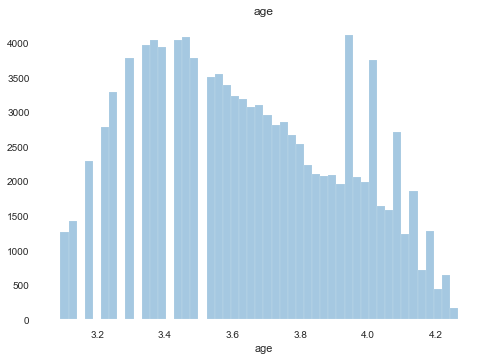

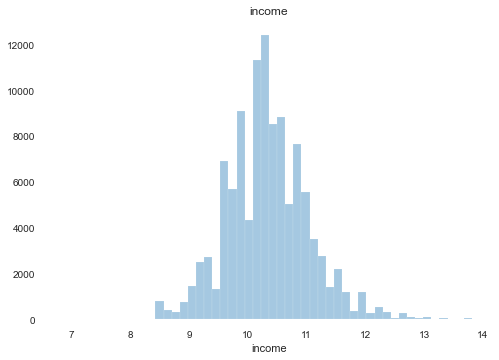

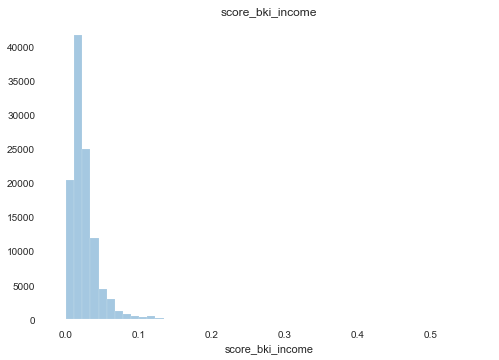

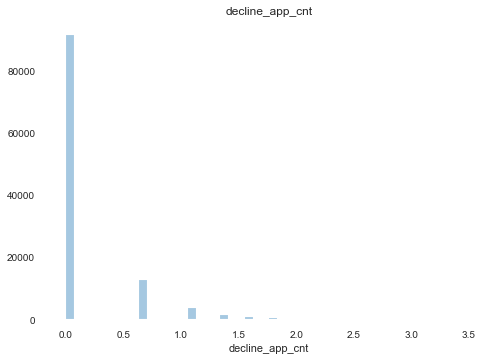

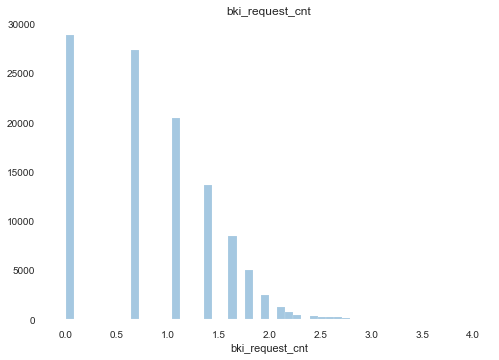

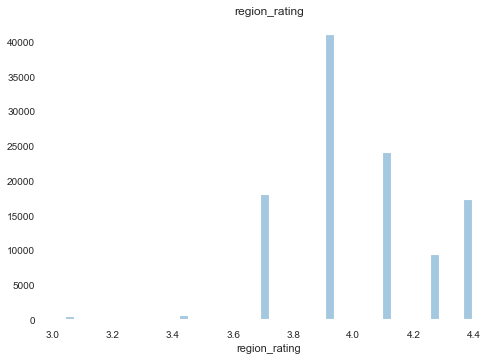

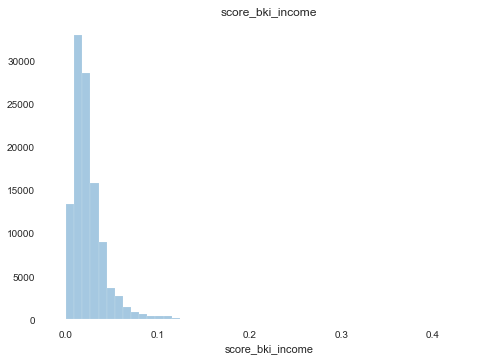

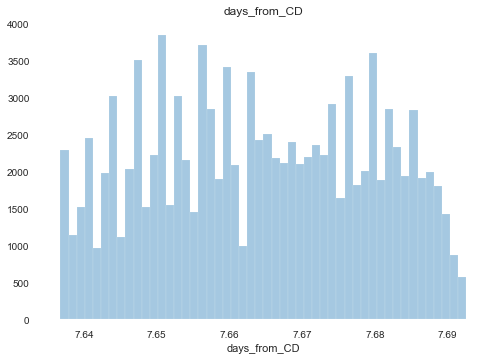

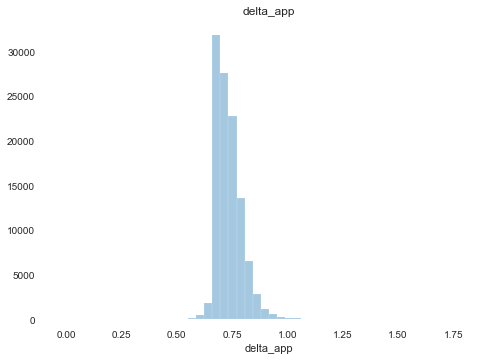

In [30]:
columns = train.columns
transform_data(True)


In [31]:
outliers_mask, outliers_freq = identify_outliers()
print(f'outliers freq = {np.round(outliers_freq*100,2)}%')

outliers freq = 6.29%


<AxesSubplot:>

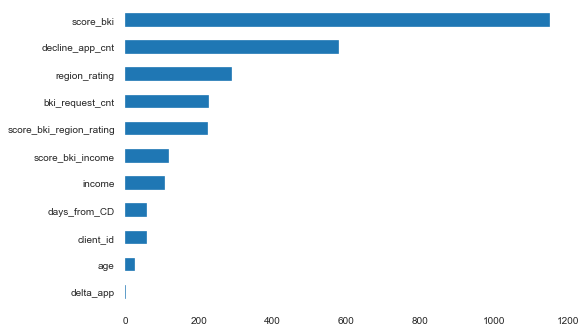

In [32]:
imp_num = Series(f_classif(train[num_cols ], train['default'])[0], index = num_cols )
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

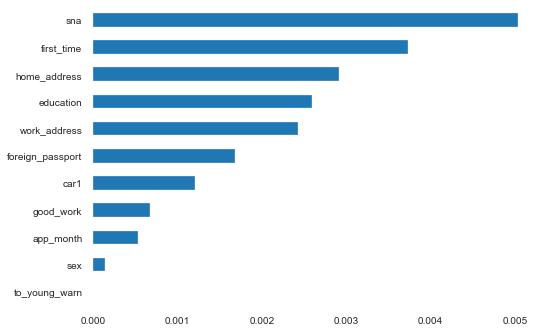

In [33]:
bin_cols.remove('train')
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [34]:
#вся работа с признаками ДО этого места!!! ЗДЕСЬ ИХ ВЫБИРАЕМ

# # числовые переменные - ЗНАЧИМЫЕ
# num_cols = ['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating'  ]
# # категориальные переменные - ЗНАЧИМЫЕ
# cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
# # бинареные переменные - ЗНАЧИМЫЕ
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'train']# 'train' - обязательно должен присутствовать

# числовые переменные - ЗНАЧИМЫЕ
num_cols = ['age',  'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating', 'score_bki_income', 'days_from_CD', 'score_bki_region_rating', 'delta_app'  ]
# категориальные переменные - ЗНАЧИМЫЕ
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'app_month', 'car1']
# бинареные переменные - ЗНАЧИМЫЕ
bin_cols = ['sex', 'good_work', 'foreign_passport', 'to_young_warn', 'train']# 'train' - обязательно должен присутствовать ПОСЛЕДНИМ

X_t, Y_t, X_kaggle = get_test_kaggle_datasets(outliers_mask)

In [35]:
oversample = BorderlineSMOTE(random_state=RANDOM_SEED, n_jobs=-1, k_neighbors=5)# k_neighbors=10, )
X_t, Y_t = oversample.fit_resample(X_t, Y_t)

In [36]:
#under = RandomUnderSampler(random_state=RANDOM_SEED, sampling_strategy=1) #????
#X_t, Y_t = under.fit_resample(X_t,Y_t)

In [37]:
# #удаляем признак см.ниже

# del_feature_list = [ 0,  1,  2,  4,  5,  7,  8,  9, 14, 15, 18, 20, 21, 22, 26, 28, 29,
#        37, 38, 40, 42, 43, 44, 47, 48, 49, 50, 53, 54, 57, 59, 60, 61, 62,
#        63, 65, 68, 70, 75, 77, 83, 88]
# X_t = np.delete(X_t, del_feature_list, axis=1) 
# X_kaggle = np.delete(X_kaggle, del_feature_list, axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_t, Y_t, test_size=0.20, random_state=RANDOM_SEED)

In [39]:
#l1 - регуляризация выбрана для борьбы с неважными признаками

In [40]:
fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [41]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# class_weight='balanced' - пропорциональное назначение весов для несбалансированных выборок
# https://github.com/scikit-learn-contrib/imbalanced-learn

#Проверяем на всей тренеровочной выборке
#model = LogisticRegression( random_state=RANDOM_SEED, penalty='l1', C=10, solver='saga',  )

model = LogisticRegressionCV(
    Cs=np.logspace(1, 40, 10)
    ,penalty='l2'
    ,scoring='roc_auc'
    ,cv=fold
    ,random_state=RANDOM_SEED
    ,max_iter=10000
    ,fit_intercept=False
    ,solver='saga'
    ,tol=10
    #,class_weight='balanced'
)
print('Проверяем на всей тренеровочной выборке')
model.fit(X_t, Y_t)
y_pred = model.predict(X_t)
show_roc_auc_score_curve_ACC_F1(model, X_t, Y_t, y_pred )
print('----------------------------------------')

Проверяем на всей тренеровочной выборке
ACC= 0.7111519182093404
F1= 0.7100004982809308
ROC AUC= 0.783210555085394
----------------------------------------


In [42]:
#Проверяем тест на тестовой выборке
print('Проверяем тест на тестовой выборке')
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
show_roc_auc_score_curve_ACC_F1(model, X_train, y_train, y_pred )
print('-----------------------------------')

Проверяем тест на тестовой выборке
ACC= 0.71362249909528
F1= 0.7251436453671268
ROC AUC= 0.7844068063899807
-----------------------------------


In [43]:
#Проверяем валидационную на тестовой выборке
print('Проверяем валидационную на тестовой выборке')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_roc_auc_score_curve_ACC_F1(model, X_test, y_test, y_pred )
print('--------------------------------------------')

Проверяем валидационную на тестовой выборке
ACC= 0.7190950825096157
F1= 0.728537170263789
ROC AUC= 0.7861502774863238
--------------------------------------------


In [44]:
#Проверка валидации по ALL
print('Проверка валидации по ALL')
model.fit(X_t, Y_t)
y_pred = model.predict(X_test)
show_roc_auc_score_curve_ACC_F1(model, X_test, y_test, y_pred )
print('--------------------------')

Проверка валидации по ALL
ACC= 0.7153314860002481
F1= 0.7122130702011121
ROC AUC= 0.783761892161043
--------------------------


У нас легкое переобучение??? или мне кажется

-----
## Отбираем только значимые признаки

The optimal number of features is 46  from 89
The selected features are:
[3, 6, 10, 11, 12, 13, 16, 19, 23, 24, 25, 27, 30, 31, 32, 33, 34, 35, 36, 39, 41, 45, 46, 51, 52, 55, 56, 58, 64, 66, 67, 69, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87]


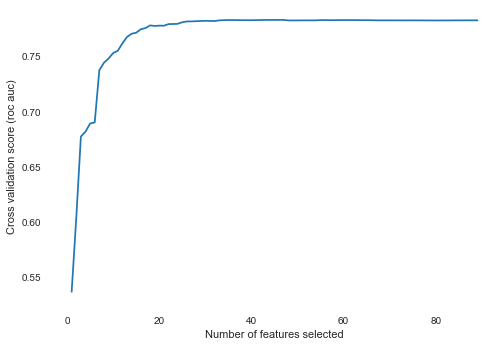

In [45]:
selector = RFECV(estimator=model, step=1, 
   cv=StratifiedKFold( n_splits=2,  shuffle=True, random_state=RANDOM_SEED), scoring='roc_auc')
selector.fit(X_test, y_test)#(X_train, y_train)
print('The optimal number of features is {}'.format(selector.n_features_), f' from {np.shape(X_test)[1]}')
features = [f for f,s in zip(range(np.shape(X_test)[1]), selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

In [46]:
#Эти фичи для удаления
del_feature_list = set(range(np.shape(X_test)[1])) - set(features)
del_feature_list = np.array(list(del_feature_list),dtype=int)


In [47]:
#удаляем признак см.ниже

X_t = np.delete(X_t, del_feature_list, axis=1) 
X_kaggle = np.delete(X_kaggle, del_feature_list, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_t, Y_t, test_size=0.20, random_state=RANDOM_SEED)

In [48]:
#Проверка с отброшенными признаками

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_roc_auc_score_curve_ACC_F1(model, X_test, y_test, y_pred )

ACC= 0.7187642168824186
F1= 0.7280217582593391
ROC AUC= 0.785731165394659


-------------------
# SUBMISSION


In [49]:
y_pred_submission = get_probs(model, X_kaggle)

In [50]:
# Формируем датасет с предсказаниями Restaurant_id -- Rating
submission_df = pd.DataFrame()
submission_df['client_id'] = train[train.train == 0]['client_id']
submission_df['default'] = y_pred_submission
submission_df

client_id   default
73799       74835  0.129783
73800       17527  0.800671
73801       75683  0.246919
73802       26883  0.339464
73803       28862  0.068200
...           ...       ...
110143      83775  0.900827
110144     106254  0.034167
110145      81852  0.838412
110146       1971  0.766208
110147      69044  0.752858

[36349 rows x 2 columns]

In [51]:
submission_df.to_csv(submission_path, index=False)